## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
from keras.layers import Dropout
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

# 防止調用 GPU 報錯：Blas GEMM launch failed
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.9 #佔用 GPU 多少比例的記憶體資源
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[2048, 1024, 512, 256, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = [0.25, 0.5, 0.75]

## 作業 1 : 請比較使用不同層數以及不同 Dropout rate 對訓練的效果

In [8]:
results = {}
for do in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with dropout = %.3f" % (do))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=do)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "do-%s" % str(do)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with dropout = 0.250
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2048)              6293504   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)    

Epoch 46/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.2547 - acc: 0.5527 - val_loss: 1.3234 - val_acc: 0.5272
Epoch 47/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.2437 - acc: 0.5563 - val_loss: 1.3279 - val_acc: 0.5286
Epoch 48/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.2419 - acc: 0.5553 - val_loss: 1.3048 - val_acc: 0.5362
Epoch 49/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.2335 - acc: 0.5598 - val_loss: 1.3081 - val_acc: 0.5368
Epoch 50/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.2240 - acc: 0.5643 - val_loss: 1.2991 - val_acc: 0.5423
Experiment with dropout = 0.500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 

Epoch 41/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.7039 - acc: 0.3640 - val_loss: 1.6126 - val_acc: 0.4106
Epoch 42/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.6961 - acc: 0.3654 - val_loss: 1.6240 - val_acc: 0.4122
Epoch 43/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6990 - acc: 0.3686 - val_loss: 1.6079 - val_acc: 0.4091
Epoch 44/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6887 - acc: 0.3684 - val_loss: 1.5933 - val_acc: 0.4145
Epoch 45/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6828 - acc: 0.3760 - val_loss: 1.5934 - val_acc: 0.4193
Epoch 46/50
50000/50000 [==============================] - 4s 86us/step - loss: 1.6742 - acc: 0.3795 - val_loss: 1.5731 - val_acc: 0.4276
Epoch 47/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.6649 - acc: 0.3822 - val_loss: 1.5786 - val_acc: 0.4232
Epoch 48/50
50000/50000 [=========

Epoch 36/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1552 - acc: 0.1648 - val_loss: 2.3399 - val_acc: 0.1020
Epoch 37/50
50000/50000 [==============================] - 4s 86us/step - loss: 2.1510 - acc: 0.1668 - val_loss: 2.3519 - val_acc: 0.1013
Epoch 38/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1496 - acc: 0.1633 - val_loss: 2.3597 - val_acc: 0.1009
Epoch 39/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1511 - acc: 0.1650 - val_loss: 2.3616 - val_acc: 0.1011
Epoch 40/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1443 - acc: 0.1658 - val_loss: 2.3749 - val_acc: 0.1001
Epoch 41/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1408 - acc: 0.1675 - val_loss: 2.3777 - val_acc: 0.1004
Epoch 42/50
50000/50000 [==============================] - 4s 87us/step - loss: 2.1388 - acc: 0.1685 - val_loss: 2.3774 - val_acc: 0.1006
Epoch 43/50
50000/50000 [=========

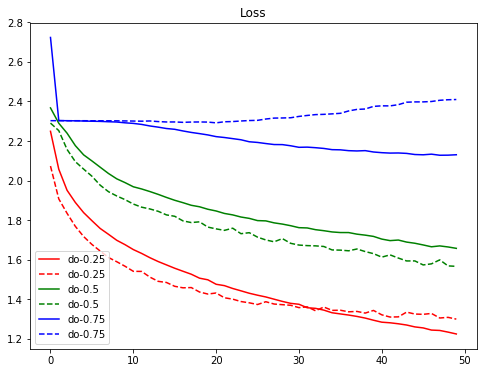

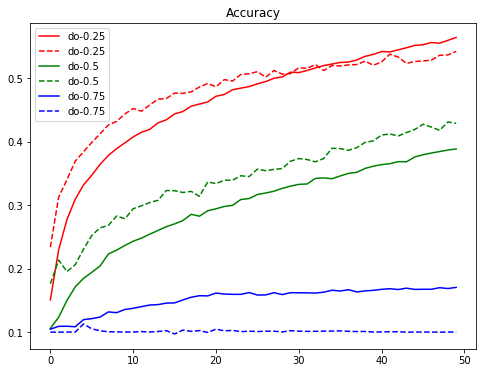

In [9]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 作業 2 : 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [10]:
results = {}
for do in Dropout_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with dropout = %.3f" % (do))
    model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=do)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0, amsgrad=False)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "do-%s" % str(do)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with dropout = 0.250
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 2048)              6293504   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)    

50000/50000 [==============================] - 5s 108us/step - loss: 1.4513 - acc: 0.4829 - val_loss: 1.4295 - val_acc: 0.4948
Epoch 46/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.4482 - acc: 0.4842 - val_loss: 1.4227 - val_acc: 0.4952
Epoch 47/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.4506 - acc: 0.4818 - val_loss: 1.4187 - val_acc: 0.4989
Epoch 48/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.4479 - acc: 0.4852 - val_loss: 1.4554 - val_acc: 0.4881
Epoch 49/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.4455 - acc: 0.4855 - val_loss: 1.4868 - val_acc: 0.4808
Epoch 50/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.4315 - acc: 0.4905 - val_loss: 1.4368 - val_acc: 0.4958
Experiment with dropout = 0.500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (Input

50000/50000 [==============================] - 5s 108us/step - loss: 1.9827 - acc: 0.2336 - val_loss: 2.0495 - val_acc: 0.2403
Epoch 40/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.9850 - acc: 0.2365 - val_loss: 2.0277 - val_acc: 0.2366
Epoch 41/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.9895 - acc: 0.2382 - val_loss: 2.0269 - val_acc: 0.2302
Epoch 42/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.9838 - acc: 0.2376 - val_loss: 2.0452 - val_acc: 0.2284
Epoch 43/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.9814 - acc: 0.2372 - val_loss: 2.0458 - val_acc: 0.2245
Epoch 44/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.9815 - acc: 0.2388 - val_loss: 2.0408 - val_acc: 0.2359
Epoch 45/50
50000/50000 [==============================] - 5s 107us/step - loss: 1.9763 - acc: 0.2415 - val_loss: 2.0596 - val_acc: 0.2194
Epoch 46/50
50000/50000 [==============

50000/50000 [==============================] - 5s 109us/step - loss: 14.5141 - acc: 0.0994 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 34/50
50000/50000 [==============================] - 5s 109us/step - loss: 14.4995 - acc: 0.1004 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 35/50
50000/50000 [==============================] - 5s 109us/step - loss: 14.5133 - acc: 0.0995 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 36/50
50000/50000 [==============================] - 5s 109us/step - loss: 14.5085 - acc: 0.0998 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 37/50
50000/50000 [==============================] - 5s 109us/step - loss: 14.5076 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 38/50
50000/50000 [==============================] - 5s 109us/step - loss: 14.5299 - acc: 0.0985 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 39/50
50000/50000 [==============================] - 5s 110us/step - loss: 14.4877 - acc: 0.1011 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 40/50
50000/50000 [

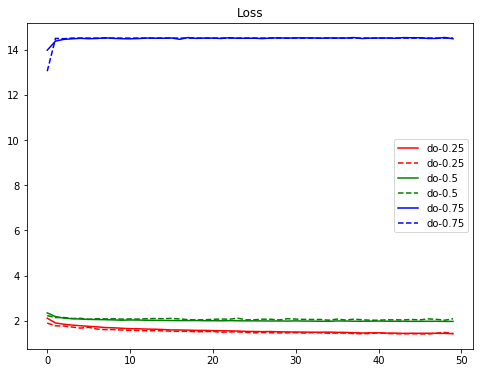

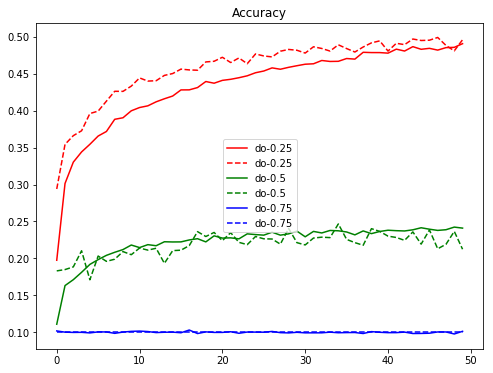

In [11]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()